In [129]:
from groo.groo import get_root
root_dir = get_root(".root_dir_covid")

import os

print(root_dir)
import sys
sys.path.append(os.path.join(root_dir, "covid-fear", "scripts"))


import numpy as np
import pandas as pd
from cov_functions import *
import seaborn as sns
from scipy import stats
import matplotlib.pyplot as plt
import warnings
import itertools
warnings.filterwarnings('ignore')
from scipy.spatial.distance import correlation as Dcorr
import bambi as bmb
import arviz as az
import json
import pickle
import bammm.bammm as mm
import pingouin as pg 


# load main dataset
df = pd.read_csv(os.path.join(root_dir, "data", "full_dataset_only_complete_based_on_sess_avg.csv"))
#sys.path.insert(1, os.path.join(root_dir, "covid-fear", "scripts", "lib", "hoeffding"))
df["cases"] = df["cases14_std_unsmooth"]
df["deaths"] = df["deaths14_std_unsmooth"]

### Meta parameters
corr_type = "spearman" # used in all analyses

no_covid_factors = 3
if no_covid_factors ==6:
    factors =[ "F1_Close_Person_Worry","F2_Anxiety_Avoidance", "F3_Economic_Impact_Worry", "F4_Prob_Estimates", "F5_Worry", "F6_Skepticism"]
elif no_covid_factors==3:
    factors = ["F1_CovidAnxietyWorry", "F2_CovidProbabilityEsts", "F3_Economic"]
    
print("State seveirty NaNs: "+str(df["state_severity"].isna().sum())+" out of entries: "+ str(df.shape[0]))

no_trait_factors = 3
trait_factor_names = ["TF1_CognAnxDepr", "TF2_PhysiolAnx", "TF3_NegativeAffect"]
trait_factor_names_short = ["TF1", "TF2", "TF3"]



mapdict = {#'TF3_NegativeAffect': 'TF3',
           #'TF2_PhysiolAnx': 'TF2', 
           #'TF1_CognAnxDepr': 'TF1',
           'stai_ta': "TA",
           'covid_worry': 'Worry', 
           'prob_est': 'RiskEsts',
           'q7_worry_econ_impact': 'EconWorry',
           'q6_apply_soc_dist': 'SocialDist',
           'q6_risk_group': 'RiskGroup',
           'avoid_beh': 'AvoidBeh',
           'avoid_anx': 'AvoidAnx',
           'q6_media_freq_num': 'InforSeek',
           'q6_media_valence': 'MediaValence',
           'q7_period_rel_danger': 'ThreatPerc',
           'deaths': 'Deaths',
           'cases': 'Cases',
           'worryhealth': 'HealthWorry',
           'q6_work_home': "WorkHome",
           'q6_houshold_membs': "HouseholdMembers",
           'sticsa_som_sa_currsess': "StateSomAnx",
       #    "q6_close_person_infdied": "ClosePDied",
            "covid_thoughts": "CovThoughts", 
            "memory_worry_infected_baselined": "MemWorry", 
            "memory_prob_infected_baselined": "MemProb", 

            #"affheallth-econ-worry": "Health>Econ \n worry", 
            #"covid_cases_est_diff": "Estimate of \n covid cases"
           }

df=df.rename(columns=mapdict)
df["TF1"] = df["TF1_CognAnxDepr"]
df["TF2"] = df["TF2_PhysiolAnx"]
df["TF3"] = df["TF3_NegativeAffect"]

# Create column with appropriate dates
df["Session"] = df["session"] + 1
df["date"] = pd.to_datetime( df["submitdate"]).dt.strftime("%B '%y")
months = df.groupby(by="Session")["date"].apply(lambda x: np.array(x.reset_index().iloc[0,1])).reset_index()
months["session"] = months["Session"]-1

vars = [
        # core things interested in 
        "Deaths",
        "Cases",
        "ThreatPerc",
        "Worry",
        "RiskEsts",
        "InforSeek",
        "AvoidBeh",
        ]

colist= [[  "navy", "dodgerblue"], ["crimson", "lightcoral"], ["xkcd:dark sea green", "xkcd:pale teal"]]

/data/drive/postdoc/Project4_covid
State seveirty NaNs: 198 out of entries: 5825


In [130]:
var1 = "x_location" 

base_path = "conditions"
final_path = base_path + "/" + var1
#os.path.join(base_path, var1, )

<AxesSubplot:>

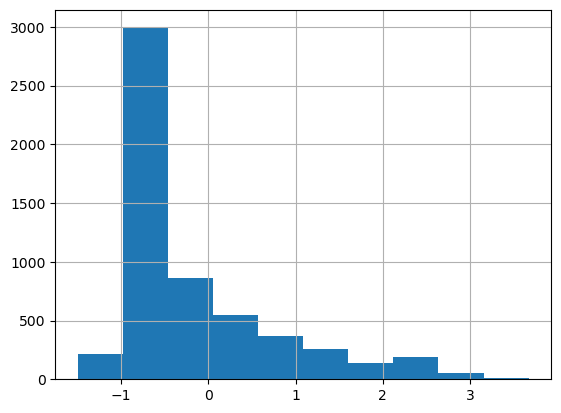

In [131]:
df["Deaths"].hist()

### Drop in variables during first wave 

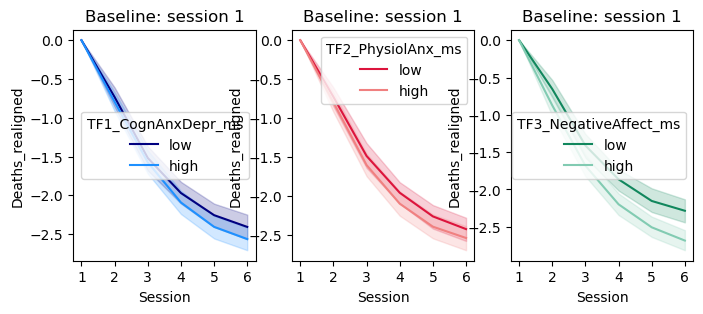

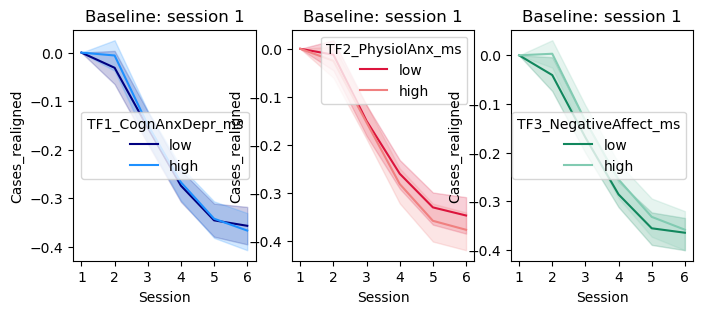

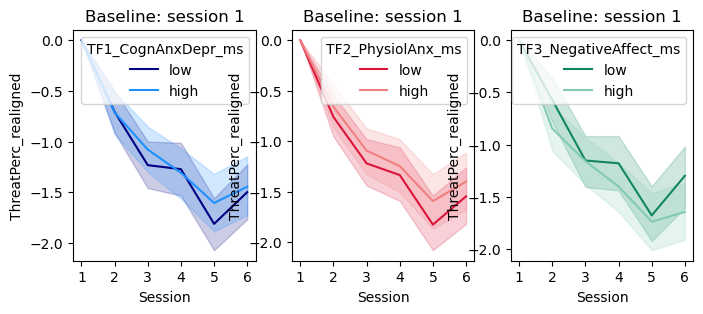

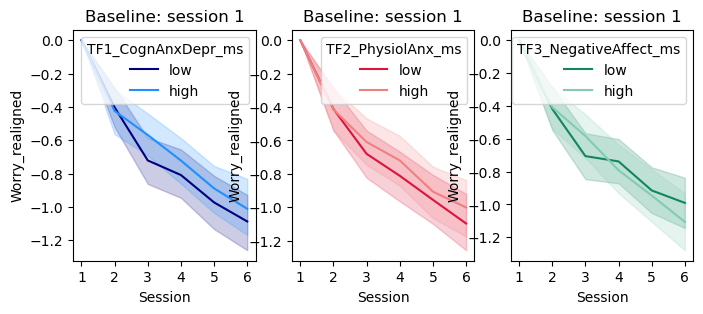

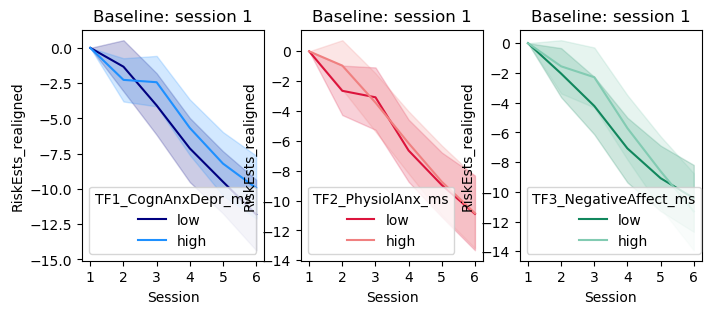

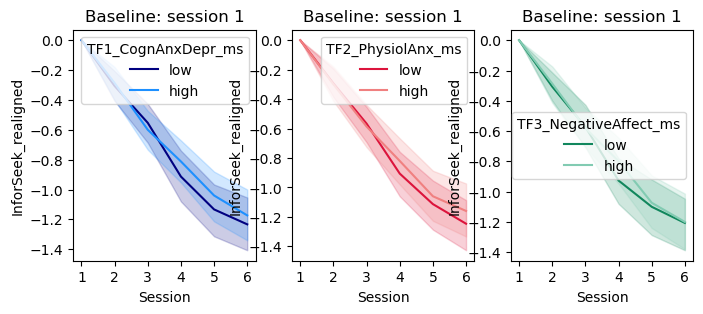

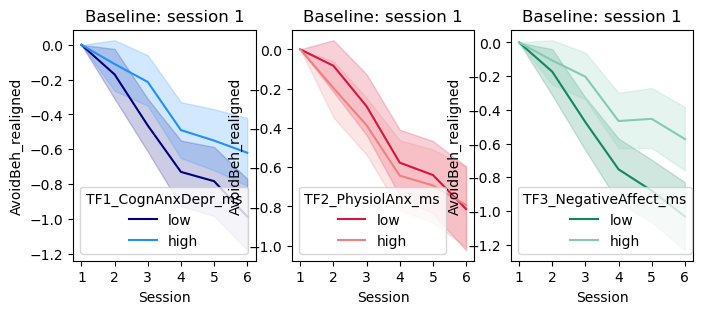

In [132]:
###
## variable used for aligning
var2use = "cases14_norm_unsmooth"
#var2use = "deaths14_norm_unsmooth"

for v in vars:
    addvars = [x+"_ms" for x in trait_factor_names  ]

    # Extract trait values for each 
    tdf = df.groupby(by=["PROLIFICID"]+addvars).mean()[trait_factor_names].reset_index()
    tdf=tdf.set_index("PROLIFICID")

    # plot
    f, ax = plt.subplots(1,3,figsize=(8,3))

    for t_idx, tf in enumerate(addvars):
        # get the realigned data for a variable of interest (F1 in this case)
        maxs=df.groupby(by=["PROLIFICID"])["session", v, var2use].apply(realign_time_series, 
                                                                                            var_to_align=v, 
                                                                                            var_align_by=var2use, 
                                                                                            prepost=5,
                                                                                            #method='cumsum-min',
                                                                                            method='fixed', 
                                                                                            sessionfix = 0,
                                                                                            baseline='lock', 
                                                                                            baseline_len=1, 
                                                                                            applyfunc='none'
                                                                                            ).reset_index()
        
        maxs=maxs.set_index("PROLIFICID")

        # join data sets 
        maxs = maxs.join(tdf, how="left")

        f = sns.lineplot(ax=ax[t_idx], data=maxs.dropna(), x="newsess", y=v+"_realigned", hue=tf, hue_order=["low", "high"], palette=colist[t_idx])
        f.set_xticks(maxs.dropna()["newsess"].unique() )#rotation = -30, ha='left')
        f.set_xticklabels(maxs.dropna()["oldsess"].unique())
        f.set_xlabel("Session")
        #f.axvline(4.5, color='black')
        f.set_title('Baseline: session 1')


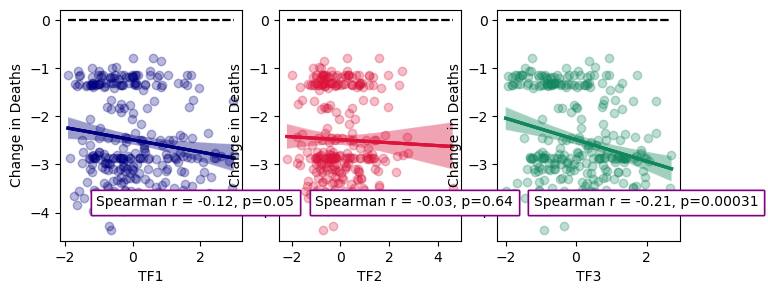

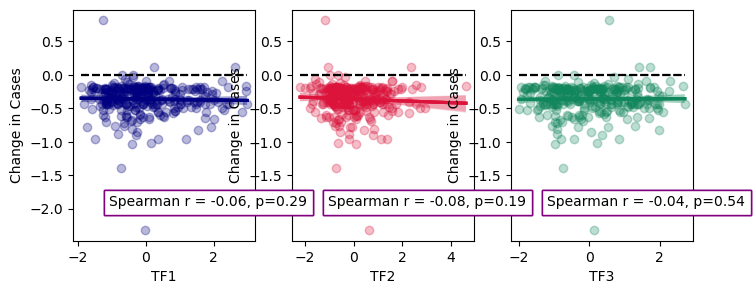

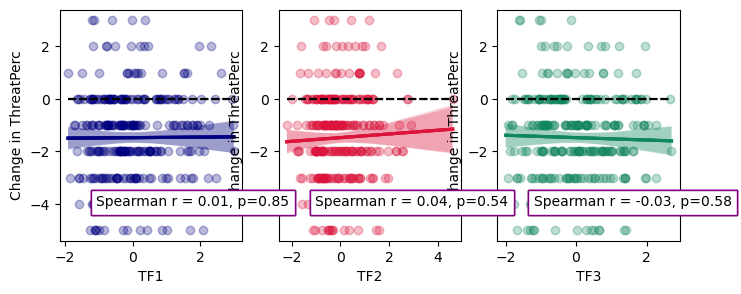

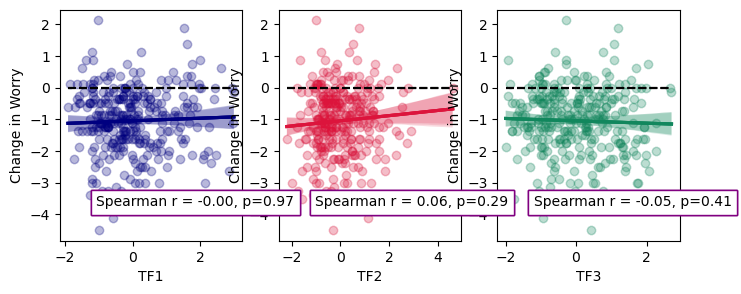

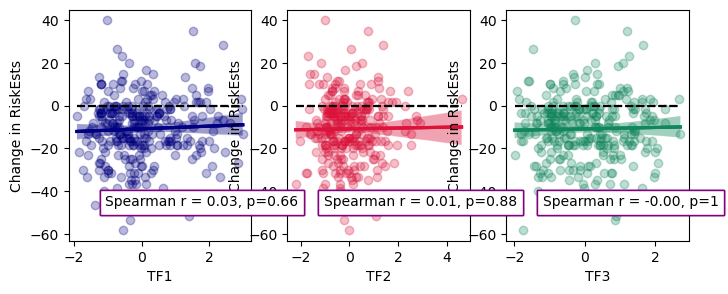

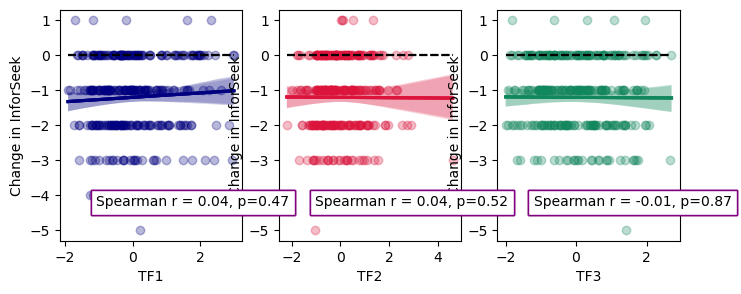

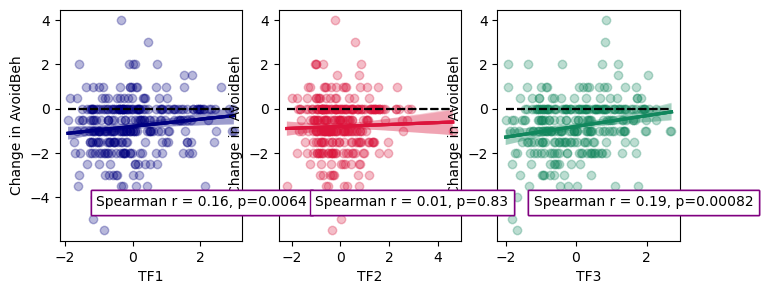

In [133]:
## variable used for aligning
var2use = "cases14_norm_unsmooth"
import pingouin as pg

#for v in vars:
sumdf = pd.DataFrame()

for vidx, v in enumerate(vars):
    #trait_factor_names = ["TF3_NegativeAffect", "TF2_PhysiolAnx", "TF1_CognAnxDepr"]
    #addvars = [x+"_ms" for x in trait_factor_names_short]

    # Extract trait values for each 
    tdf = df.groupby(by=["PROLIFICID"]).mean()[trait_factor_names_short].reset_index()
    tdf=tdf.set_index("PROLIFICID")

    # plot
    f, ax = plt.subplots(1,3,figsize=(8,3))

    # get the realigned data for a variable of interest (F1 in this case)
    maxs=df.groupby(by=["PROLIFICID"])["session", v, var2use].apply(realign_time_series, 
                                                                                        var_to_align=v, 
                                                                                        var_align_by=var2use, 
                                                                                        method='fixed',
                                                                                        sessionfix = 0,
                                                                                        baseline_len = 1,
                                                                                        applyfunc='none',
                                                                                        baseline='none').reset_index()
    maxs['oldsess'].replace({1:'pre',   6:'post'}, inplace=True)
    maxs = maxs.loc[maxs["oldsess"].isin(['pre', 'post']),:]

    # join data sets 
    
    maxs = maxs.loc[:,["oldsess", "PROLIFICID", v+"_realigned"]].groupby(by=["oldsess", "PROLIFICID"]).mean().reset_index()
    maxs = maxs.pivot(columns="oldsess", index="PROLIFICID", values=v+"_realigned")

    maxs["prepost"] =   maxs["post"] - maxs["pre"]
    #maxs=maxs.set_index("PROLIFICID")["AvoidBeh"]:#pre"]
    maxs = maxs.join(tdf, how="left")

    ### for export 
    ccf = maxs.copy()
    ccf = ccf.rename(columns={"pre": "pre_"+v, "post": "post_"+v, "prepost": "prepost_"+v})
    if vidx == 0:
        ppdata = ccf
        ppdata["wave"] = "first_wave"
    else:
        ppdata = ppdata.join(ccf.loc[:,["pre_"+v, "post_"+v,  "prepost_"+v]])


    # Gather summary data
    stats = maxs[['pre', 'post', 'prepost']].agg(['mean', 'std'])
    stats.loc['se'] = stats.loc['std'] / np.sqrt(len(maxs))
    summary_data = {}

    for stat in stats.index:  # Iterate over 'mean', 'std', 'se'
        for col in stats.columns:  # Iterate over 'pre', 'post', 'prepost'
            summary_data[f'{col}_{stat}'] = stats.loc[stat, col]

    # Flatten the MultiIndex resulting from the aggregation
    #stats.columns = [f'{col}_{idx}' for col, idx in stats.columns]

    # Step 2: Calculate Spearman correlations for pre, post, and prepost with TF1, TF2, and TF3
    for variable in ['pre', 'post', 'prepost']:
        for tf in ['TF1', 'TF2', 'TF3']:
            corr = pg.corr(maxs[variable], maxs[tf], method='spearman')
            ci_lower, ci_upper = corr['CI95%'].values[0]  # Split the CI95% into lower and upper bounds
            summary_data.update({
                f'{variable}_{tf}_rho': corr['r'].values[0],
                f'{variable}_{tf}_pval': corr['p-val'].values[0],
                f'{variable}_{tf}_CI_lower': ci_lower,
                f'{variable}_{tf}_CI_upper': ci_upper
            })

    ttf = pd.DataFrame([summary_data])
    ttf["var"] = v
    sumdf = pd.concat([sumdf, ttf])

 

    for t_idx, tf in enumerate(addvars):
        for ttidx, tt in enumerate(trait_factor_names_short):
            #ax[ttidx] = sns.regplot(data=maxs, x=tt, y="prepost", ax=ax[ttidx], line_kws={'color': 'red'}, scatter_kws={'color':'pink','alpha':0.3})
            ax[ttidx] = sns.regplot(data=maxs, x=tt, y="prepost", ax=ax[ttidx], line_kws={'color': colist[ttidx][0]}, scatter_kws={'color':colist[ttidx][0]  ,'alpha':0.1})
            corrfunc(maxs[tt], maxs["prepost"], drop_missing=True, tests=["spearman"], ax=ax[ttidx], xanchor=0.2)
            ax[ttidx].set_ylabel("Change in "+v)
            ax[ttidx].plot([min(maxs[tt]), max(maxs[tt])], [0,0], 'k--')

        #plt.savefig(os.path.join(root_dir, 'covid-fear', 'scripts', 'submissions_and_outputs',  'PUG_2024', 'raw_plots', 'ER_ext_'+v+'.pdf'), dpi=300, quality=80, optimize=True, progressive=True)  
    
ppdata.to_csv(os.path.join(root_dir, "output", "prepost", "first_wave_full_prepost_data.csv"))

### Export change data for first wave

In [134]:
sumdf.columns

Index(['pre_mean', 'post_mean', 'prepost_mean', 'pre_std', 'post_std',
       'prepost_std', 'pre_se', 'post_se', 'prepost_se', 'pre_TF1_rho',
       'pre_TF1_pval', 'pre_TF1_CI_lower', 'pre_TF1_CI_upper', 'pre_TF2_rho',
       'pre_TF2_pval', 'pre_TF2_CI_lower', 'pre_TF2_CI_upper', 'pre_TF3_rho',
       'pre_TF3_pval', 'pre_TF3_CI_lower', 'pre_TF3_CI_upper', 'post_TF1_rho',
       'post_TF1_pval', 'post_TF1_CI_lower', 'post_TF1_CI_upper',
       'post_TF2_rho', 'post_TF2_pval', 'post_TF2_CI_lower',
       'post_TF2_CI_upper', 'post_TF3_rho', 'post_TF3_pval',
       'post_TF3_CI_lower', 'post_TF3_CI_upper', 'prepost_TF1_rho',
       'prepost_TF1_pval', 'prepost_TF1_CI_lower', 'prepost_TF1_CI_upper',
       'prepost_TF2_rho', 'prepost_TF2_pval', 'prepost_TF2_CI_lower',
       'prepost_TF2_CI_upper', 'prepost_TF3_rho', 'prepost_TF3_pval',
       'prepost_TF3_CI_lower', 'prepost_TF3_CI_upper', 'var'],
      dtype='object')

In [135]:

sumdf.to_csv(os.path.join(root_dir, "output", "prepost", "first_wave_extensive.csv"))

expvars = ['var', 'pre_mean', 'post_mean', 'prepost_mean','prepost_TF1_rho',
       'prepost_TF1_pval', 'prepost_TF1_CI_lower', 'prepost_TF1_CI_upper',
       'prepost_TF2_rho', 'prepost_TF2_pval', 'prepost_TF2_CI_lower',
       'prepost_TF2_CI_upper', 'prepost_TF3_rho', 'prepost_TF3_pval',
       'prepost_TF3_CI_lower', 'prepost_TF3_CI_upper' ]
sumdf.loc[:,expvars].to_csv(os.path.join(root_dir, "output", "prepost", "first_wave_focused.csv"))

In [136]:
## Correct p-values

In [137]:
sumdf

pre_mean  post_mean  prepost_mean    pre_std   post_std  prepost_std  \
0   1.832867  -0.650522     -2.485337   0.920416   0.150594     0.934199   
0  -0.299754  -0.661279     -0.361911   0.199430   0.113375     0.239015   
0   5.450000   3.976667     -1.473333   1.251421   1.567689     1.766264   
0   4.441667   3.392917     -1.048750   1.281148   1.376820     1.049799   
0  43.283333  32.416667    -10.866667  16.938894  18.977056    15.099349   
0   4.610000   3.406667     -1.203333   0.677814   1.219116     1.128228   
0   5.998333   5.195000     -0.803333   1.206517   1.598330     1.279366   

     pre_se   post_se  prepost_se  pre_TF1_rho  ...  prepost_TF1_CI_upper  \
0  0.053140  0.008695    0.053936     0.118790  ...                 -0.00   
0  0.011514  0.006546    0.013800     0.029895  ...                  0.05   
0  0.072251  0.090511    0.101975     0.223905  ...                  0.12   
0  0.073967  0.079491    0.060610     0.366946  ...                  0.11   
0  0.977968  1.095641    0.871761     0.232594  ...                  0.14   
0  0.039134  0.070386    0.065138     0.005583  ...                  0.15   
0  0.069658  0.092280    0.073864     0.149119  ...                  0.27   

   prepost_TF2_rho  prepost_TF2_pval  prepost_TF2_CI_lower  \
0        -0.027363          0.643769                 -0.14   
0        -0.075908          0.191294                 -0.19   
0         0.035907          0.535571                 -0.08   
0         0.060924          0.292890                 -0.05   
0         0.008883          0.878219                 -0.10   
0         0.037217          0.520779                 -0.08   
0         0.012704          0.826550                 -0.10   

   prepost_TF2_CI_upper  prepost_TF3_rho  prepost_TF3_pval  \
0                  0.09        -0.211013          0.000311   
0                  0.04        -0.035736          0.538885   
0                  0.15        -0.032353          0.576723   
0                  0.17        -0.048120          0.406278   
0                  0.12        -0.000160          0.997798   
0                  0.15        -0.009343          0.871971   
0                  0.13         0.192169          0.000820   

   prepost_TF3_CI_lower  prepost_TF3_CI_upper         var  
0                 -0.32                 -0.10      Deaths  
0                 -0.15                  0.08       Cases  
0                 -0.15                  0.08  ThreatPerc  
0                 -0.16                  0.07       Worry  
0                 -0.11                  0.11    RiskEsts  
0                 -0.12                  0.10   InforSeek  
0                  0.08                  0.30    AvoidBeh  

[7 rows x 46 columns]

In [138]:
# PRE
pvs = sumdf.loc[:,["var"]+["pre_"+x+"_pval" for x in ["TF1", "TF2", "TF3"]]].melt(value_name="pval", id_vars="var")
pvs.loc[:,"pval_corr"] = np.round(pg.multicomp(pvs["pval"], alpha=0.05, method="holm")[1] ,4)
pvs



var      variable          pval  pval_corr
0       Deaths  pre_TF1_pval  4.397758e-02     0.3958
1        Cases  pre_TF1_pval  6.072425e-01     1.0000
2   ThreatPerc  pre_TF1_pval  9.163831e-05     0.0016
3        Worry  pre_TF1_pval  5.403031e-11     0.0000
4     RiskEsts  pre_TF1_pval  4.746925e-05     0.0009
5    InforSeek  pre_TF1_pval  9.232866e-01     1.0000
6     AvoidBeh  pre_TF1_pval  9.695290e-03     0.1066
7       Deaths  pre_TF2_pval  3.369423e-01     1.0000
8        Cases  pre_TF2_pval  1.248209e-01     0.8737
9   ThreatPerc  pre_TF2_pval  1.547941e-02     0.1548
10       Worry  pre_TF2_pval  2.478636e-04     0.0037
11    RiskEsts  pre_TF2_pval  1.892070e-04     0.0030
12   InforSeek  pre_TF2_pval  6.965971e-01     1.0000
13    AvoidBeh  pre_TF2_pval  5.791022e-02     0.4633
14      Deaths  pre_TF3_pval  2.712633e-04     0.0038
15       Cases  pre_TF3_pval  5.811869e-01     1.0000
16  ThreatPerc  pre_TF3_pval  5.582966e-05     0.0010
17       Worry  pre_TF3_pval  1.782385e-13     0.0000
18    RiskEsts  pre_TF3_pval  1.443907e-03     0.0173
19   InforSeek  pre_TF3_pval  9.028970e-01     1.0000
20    AvoidBeh  pre_TF3_pval  9.845854e-04     0.0128

In [139]:
# POST
pvs = sumdf.loc[:,["var"]+["post_"+x+"_pval" for x in ["TF1", "TF2", "TF3"]]].melt(value_name="pval", id_vars="var")
pvs.loc[:,"pval_corr"] = np.round(pg.multicomp(pvs["pval"], alpha=0.05, method="holm")[1] ,4)
pvs


var       variable          pval  pval_corr
0       Deaths  post_TF1_pval  4.026216e-01     1.0000
1        Cases  post_TF1_pval  7.660250e-02     0.6128
2   ThreatPerc  post_TF1_pval  7.707343e-04     0.0116
3        Worry  post_TF1_pval  1.406910e-10     0.0000
4     RiskEsts  post_TF1_pval  3.523100e-05     0.0006
5    InforSeek  post_TF1_pval  3.789947e-01     1.0000
6     AvoidBeh  post_TF1_pval  3.592263e-04     0.0057
7       Deaths  post_TF2_pval  1.203928e-01     0.8427
8        Cases  post_TF2_pval  5.165007e-01     1.0000
9   ThreatPerc  post_TF2_pval  2.257764e-02     0.2258
10       Worry  post_TF2_pval  1.386572e-05     0.0002
11    RiskEsts  post_TF2_pval  8.198894e-04     0.0116
12   InforSeek  post_TF2_pval  5.789898e-01     1.0000
13    AvoidBeh  post_TF2_pval  1.668297e-01     1.0000
14      Deaths  post_TF3_pval  2.902748e-02     0.2612
15       Cases  post_TF3_pval  5.767009e-03     0.0692
16  ThreatPerc  post_TF3_pval  1.043416e-02     0.1148
17       Worry  post_TF3_pval  9.093686e-10     0.0000
18    RiskEsts  post_TF3_pval  2.892294e-03     0.0376
19   InforSeek  post_TF3_pval  9.230032e-01     1.0000
20    AvoidBeh  post_TF3_pval  4.679403e-06     0.0001

In [140]:
# PREPOST
pvs = sumdf.loc[:,["var"]+["prepost_"+x+"_pval" for x in ["TF1", "TF2", "TF3"]]].melt(value_name="pval", id_vars="var")
pvs.loc[:,"pval_corr"] = np.round(pg.multicomp(pvs["pval"], alpha=0.05, method="holm")[1] ,4)
pvs


var          variable      pval  pval_corr
0       Deaths  prepost_TF1_pval  0.049794     0.8963
1        Cases  prepost_TF1_pval  0.291575     1.0000
2   ThreatPerc  prepost_TF1_pval  0.854970     1.0000
3        Worry  prepost_TF1_pval  0.967851     1.0000
4     RiskEsts  prepost_TF1_pval  0.663911     1.0000
5    InforSeek  prepost_TF1_pval  0.472233     1.0000
6     AvoidBeh  prepost_TF1_pval  0.006386     0.1213
7       Deaths  prepost_TF2_pval  0.643769     1.0000
8        Cases  prepost_TF2_pval  0.191294     1.0000
9   ThreatPerc  prepost_TF2_pval  0.535571     1.0000
10       Worry  prepost_TF2_pval  0.292890     1.0000
11    RiskEsts  prepost_TF2_pval  0.878219     1.0000
12   InforSeek  prepost_TF2_pval  0.520779     1.0000
13    AvoidBeh  prepost_TF2_pval  0.826550     1.0000
14      Deaths  prepost_TF3_pval  0.000311     0.0065
15       Cases  prepost_TF3_pval  0.538885     1.0000
16  ThreatPerc  prepost_TF3_pval  0.576723     1.0000
17       Worry  prepost_TF3_pval  0.406278     1.0000
18    RiskEsts  prepost_TF3_pval  0.997798     1.0000
19   InforSeek  prepost_TF3_pval  0.871971     1.0000
20    AvoidBeh  prepost_TF3_pval  0.000820     0.0164

### Correct all three 

In [141]:
for w in ["pre", "post", "prepost"]:
    pvs = sumdf.loc[:,["var"]+[w+"_"+x+"_pval" for x in ["TF1", "TF2", "TF3"]]].melt(value_name="pval", id_vars="var")
    pvs.loc[:,"pval_corr"] = pg.multicomp(pvs["pval"], alpha=0.05, method="holm")[1]
    app = pvs.pivot(columns="variable", index="var", values=["pval_corr"])
    app.columns = app.columns.get_level_values(1)
    app = app.rename(columns={w+"_TF1_pval": w+"_TF1_pval_corr", 
                        w+"_TF2_pval": w+"_TF2_pval_corr",
                        w+"_TF3_pval": w+"_TF3_pval_corr"})

    sumdf = sumdf.set_index("var").join(app).reset_index()



In [142]:
summary_df = sumdf.copy()
summary_df.index = vars  # Setting the index to vars (your variable names)
summary_df = summary_df.T  # Transposing the DataFrame for easier access

### Export table as docx

In [143]:
from docx import Document
from docx.shared import Inches, Pt
from docx.enum.table import WD_ALIGN_VERTICAL, WD_TABLE_ALIGNMENT
from docx.enum.text import WD_ALIGN_PARAGRAPH
import os

# Create a new Document
doc = Document()

# Set the document to landscape orientation
section = doc.sections[-1]
section.orientation = 1  # Set orientation to landscape
new_width, new_height = section.page_height, section.page_width
section.page_width = new_width
section.page_height = new_height

# Set margins (optional)
section.top_margin = Inches(1)
section.bottom_margin = Inches(1)
section.left_margin = Inches(1)
section.right_margin = Inches(1)

# Create the table with the appropriate number of rows and columns
rows = len(vars) + 2  # +2 for the header rows
cols = 13  # Variable column + 3 (pre, post, prepost) for Summary + 9 for TF1, TF2, TF3

table = doc.add_table(rows=rows, cols=cols)

# Set table alignment to center
table.alignment = WD_TABLE_ALIGNMENT.CENTER

# Add header rows
header_cells = table.rows[0].cells
header_cells[0].text = "Variable"
header_cells[1].text = "Summary"
header_cells[4].text = "TF1"
header_cells[7].text = "TF2"
header_cells[10].text = "TF3"

# Merge header cells for subcolumns
header_cells[1].merge(header_cells[2]).merge(header_cells[3])
header_cells[4].merge(header_cells[5]).merge(header_cells[6])
header_cells[7].merge(header_cells[8]).merge(header_cells[9])
header_cells[10].merge(header_cells[11]).merge(header_cells[12])

# Add subheader row
subheader_cells = table.rows[1].cells
subheader_cells[1].text = "Pre"
subheader_cells[2].text = "Post"
subheader_cells[3].text = "Prepost"
subheader_cells[4].text = "Pre"
subheader_cells[5].text = "Post"
subheader_cells[6].text = "Prepost"
subheader_cells[7].text = "Pre"
subheader_cells[8].text = "Post"
subheader_cells[9].text = "Prepost"
subheader_cells[10].text = "Pre"
subheader_cells[11].text = "Post"
subheader_cells[12].text = "Prepost"

# Define column widths
for cell in table.columns[1].cells:
    cell.width = Inches(0.8)  # Narrower summary columns
for i in range(4, 13):
    for cell in table.columns[i].cells:
        cell.width = Inches(0.7)  # 20% narrower for TF1-TF3 subcolumns

# Add the table data
for i, var in enumerate(vars):
    row_cells = table.rows[i + 2].cells
    row_cells[0].text = var  # Variable name
    row_cells[1].text = f"{summary_df[var]['pre_mean']:.2f} ± {summary_df[var]['pre_std']:.2f}"
    row_cells[2].text = f"{summary_df[var]['post_mean']:.2f} ± {summary_df[var]['post_std']:.2f}"
    row_cells[3].text = f"{summary_df[var]['prepost_mean']:.2f} ± {summary_df[var]['prepost_std']:.2f}"

    def format_docx_correlation(cell, rho, pval_uncorr, pval_corr, ci_lower, ci_upper):
        p = cell.paragraphs[0]
        run = p.add_run(f"ρ={rho:.2f}\n")
        run.italic = True

        run = p.add_run(f"CI95=[{ci_lower:.2f}, {ci_upper:.2f}]\n")
        run = p.add_run("p<0.001" if pval_uncorr < 0.001 else f"p={pval_uncorr:.3f}")
        run = p.add_run("\n")
        run = p.add_run("pcorr<0.001" if pval_corr < 0.001 else f"pcorr={pval_corr:.3f}")

        if pval_corr < 0.05:
            for run in p.runs:  # Apply bold to the entire cell content
                run.bold = True
        p.alignment = WD_ALIGN_PARAGRAPH.CENTER

    format_docx_correlation(row_cells[4], summary_df[var]['pre_TF1_rho'], summary_df[var]['pre_TF1_pval'], summary_df[var]['pre_TF1_pval_corr'], summary_df[var]['pre_TF1_CI_lower'], summary_df[var]['pre_TF1_CI_upper'])
    format_docx_correlation(row_cells[5], summary_df[var]['post_TF1_rho'], summary_df[var]['post_TF1_pval'], summary_df[var]['post_TF1_pval_corr'], summary_df[var]['post_TF1_CI_lower'], summary_df[var]['post_TF1_CI_upper'])
    format_docx_correlation(row_cells[6], summary_df[var]['prepost_TF1_rho'], summary_df[var]['prepost_TF1_pval'], summary_df[var]['prepost_TF1_pval_corr'], summary_df[var]['prepost_TF1_CI_lower'], summary_df[var]['prepost_TF1_CI_upper'])

    format_docx_correlation(row_cells[7], summary_df[var]['pre_TF2_rho'], summary_df[var]['pre_TF2_pval'], summary_df[var]['pre_TF2_pval_corr'], summary_df[var]['pre_TF2_CI_lower'], summary_df[var]['pre_TF2_CI_upper'])
    format_docx_correlation(row_cells[8], summary_df[var]['post_TF2_rho'], summary_df[var]['post_TF2_pval'], summary_df[var]['post_TF2_pval_corr'], summary_df[var]['post_TF2_CI_lower'], summary_df[var]['post_TF2_CI_upper'])
    format_docx_correlation(row_cells[9], summary_df[var]['prepost_TF2_rho'], summary_df[var]['prepost_TF2_pval'], summary_df[var]['prepost_TF2_pval_corr'], summary_df[var]['prepost_TF2_CI_lower'], summary_df[var]['prepost_TF2_CI_upper'])

    format_docx_correlation(row_cells[10], summary_df[var]['pre_TF3_rho'], summary_df[var]['pre_TF3_pval'], summary_df[var]['pre_TF3_pval_corr'], summary_df[var]['pre_TF3_CI_lower'], summary_df[var]['pre_TF3_CI_upper'])
    format_docx_correlation(row_cells[11], summary_df[var]['post_TF3_rho'], summary_df[var]['post_TF3_pval'], summary_df[var]['post_TF3_pval_corr'], summary_df[var]['post_TF3_CI_lower'], summary_df[var]['post_TF3_CI_upper'])
    format_docx_correlation(row_cells[12], summary_df[var]['prepost_TF3_rho'], summary_df[var]['prepost_TF3_pval'], summary_df[var]['prepost_TF3_pval_corr'], summary_df[var]['prepost_TF3_CI_lower'], summary_df[var]['prepost_TF3_CI_upper'])

# Adjust font size and style for the entire table
for row in table.rows:
    for cell in row.cells:
        for paragraph in cell.paragraphs:
            for run in paragraph.runs:
                run.font.size = Pt(6)  # Reduce the font size by 40%
                run.font.name = 'Calibri'

# Save the document
doc_output_path = os.path.join(root_dir, "output", "prepost", "wave1_table.docx")
doc.save(doc_output_path)

print(f"Word document has been created and saved to {doc_output_path}")


Word document has been created and saved to /data/drive/postdoc/Project4_covid/output/prepost/wave1_table.docx


# Second wave 

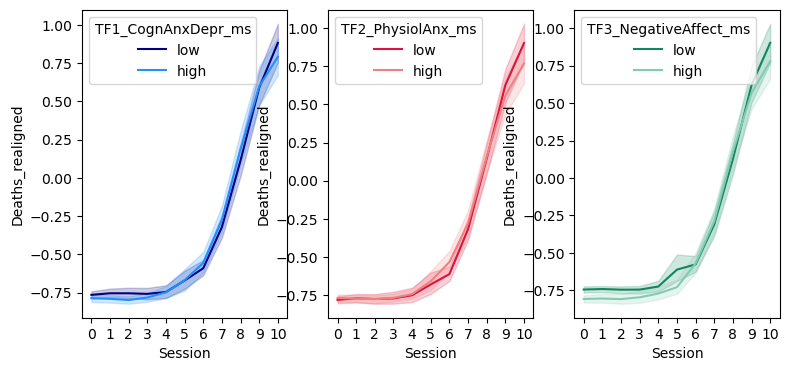

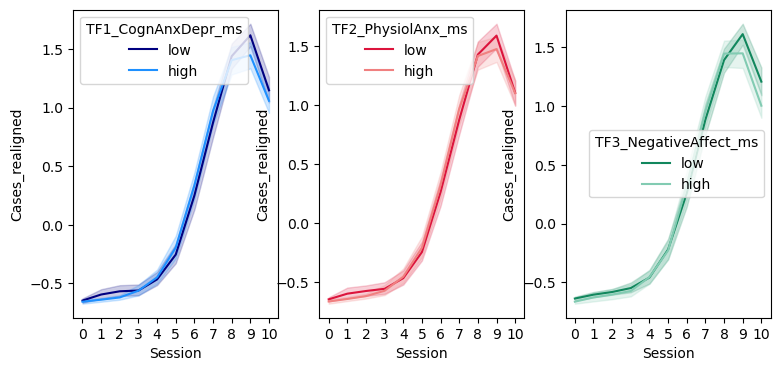

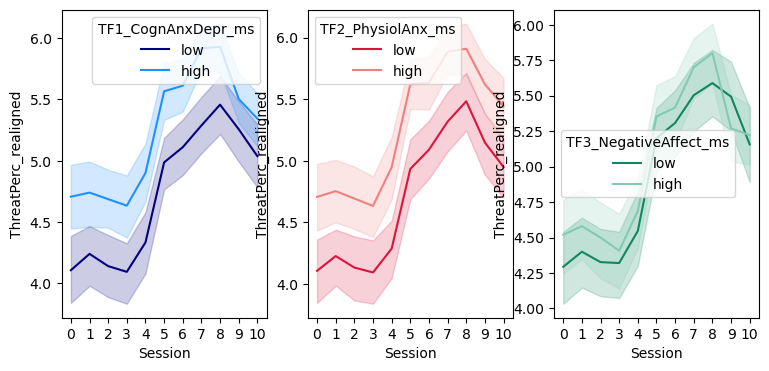

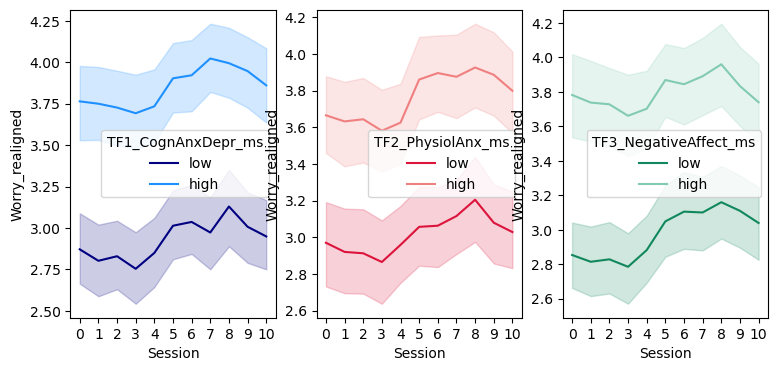

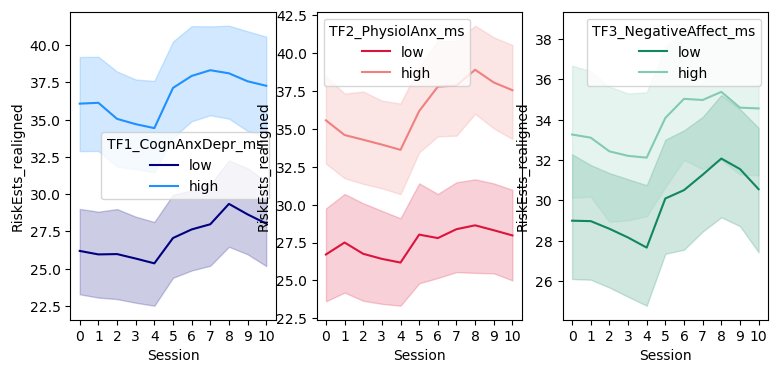

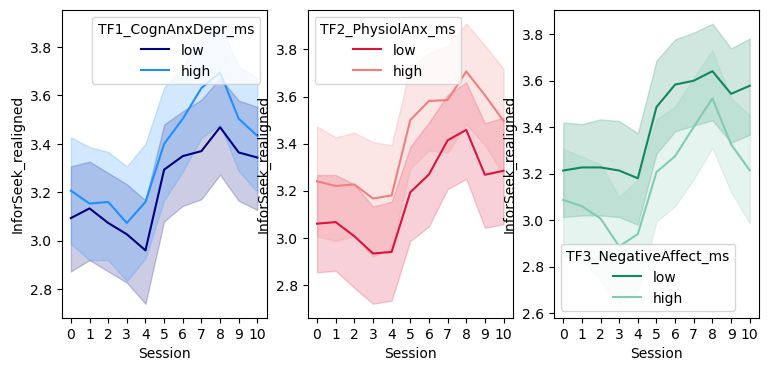

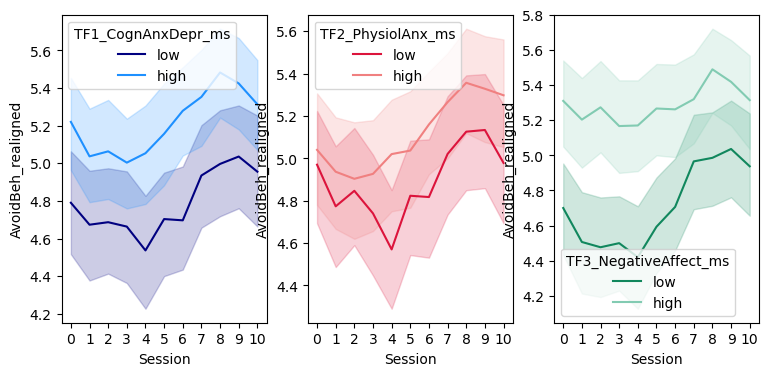

In [144]:
## variable used for aligning
var2use = "cases14_norm_unsmooth"
#var2use = "deaths14_norm_unsmooth"

for v in vars:
    addvars = [x+"_ms" for x in trait_factor_names]

    # Extract trait values for each 
    tdf = df.groupby(by=["PROLIFICID"]+addvars).mean()[trait_factor_names].reset_index()
    tdf=tdf.set_index("PROLIFICID")

    # get the realigned data for a variable of interest (F1 in this case)
    maxs=df.groupby(by=["PROLIFICID"])["session", v, var2use].apply(realign_time_series, 
                                                                                        var_to_align=v, 
                                                                                        var_align_by=var2use, 
                                                                                        baseline='none', 
                                                                                        applyfunc='none', 
                                                                                        #method='cumsum-min',
                                                                                        method='fixed',
                                                                                        sessionfix =13,
                                                                                        ).reset_index()
    
    #method='fixed',
    #sessionfix =0,
    #baseline='lock', 
    #applyfunc='standardize'

    maxs=maxs.set_index("PROLIFICID")

    # join data sets 
    maxs = maxs.join(tdf, how="left")

    # plot
    f, ax = plt.subplots(1,3,figsize=(9,4))

    for t_idx, tf in enumerate(addvars):
        

        f = sns.lineplot(ax=ax[t_idx], data=maxs.dropna(), x="newsess", y=v+"_realigned", hue=tf, hue_order=["low", "high"], palette=colist[t_idx])
        f.set_xticks(maxs.dropna()["newsess"].unique() )#rotation = -30, ha='left')
        #f.set_xticklabels(maxs.dropna()["oldsess"].unique())
        f.set_xlabel("Session")

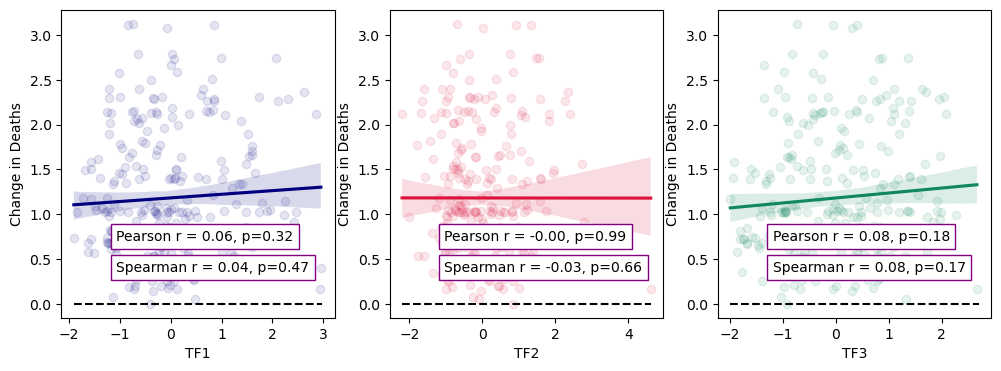

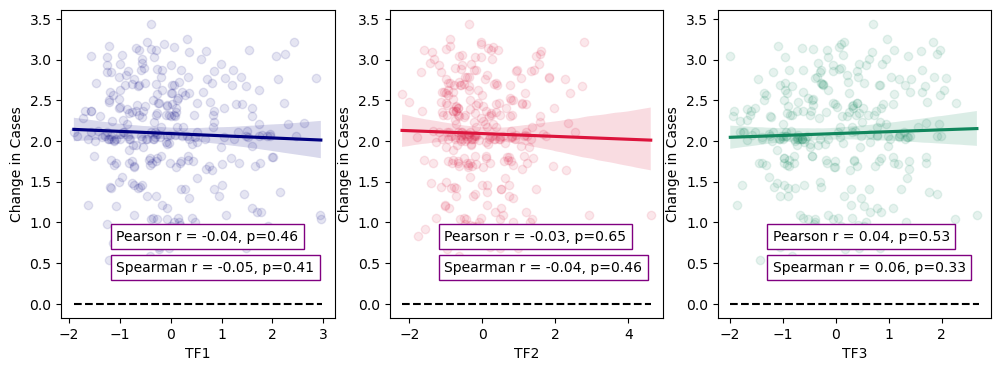

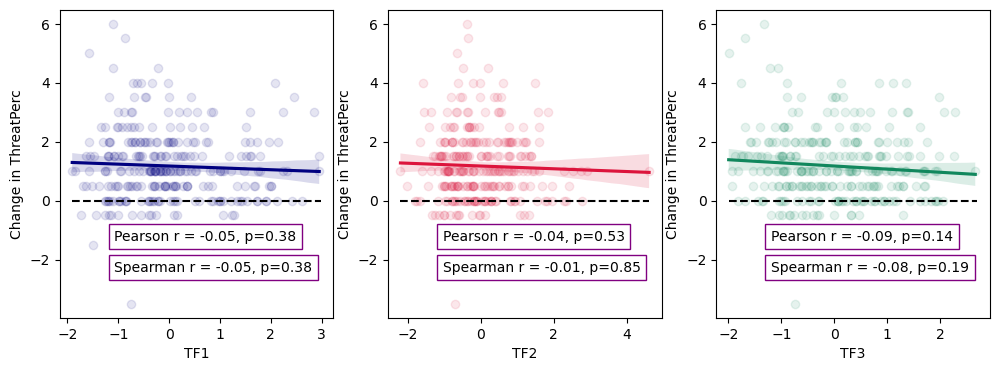

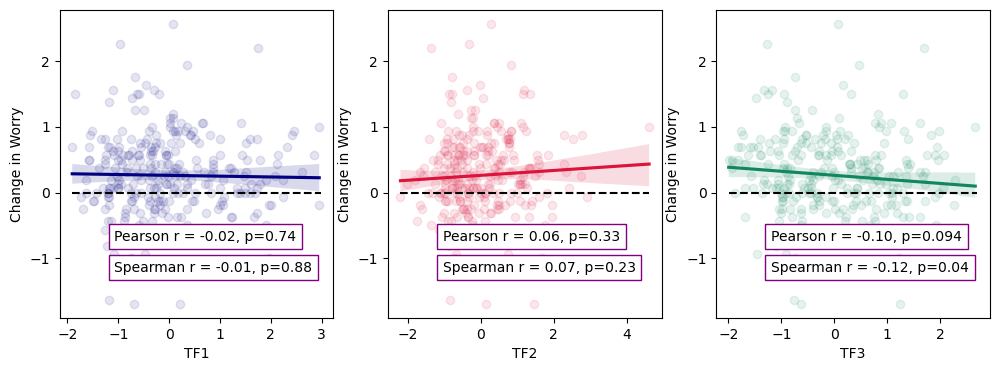

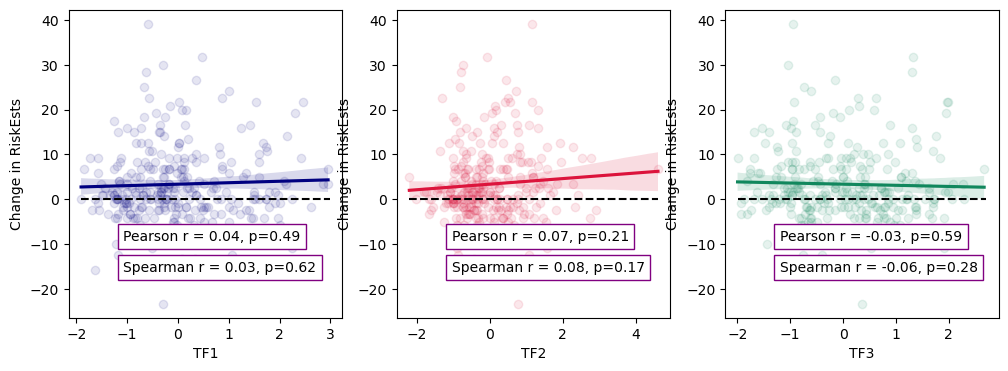

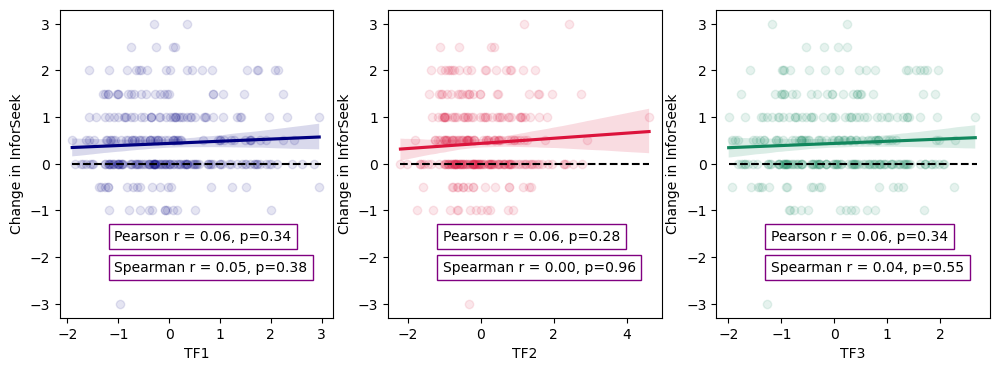

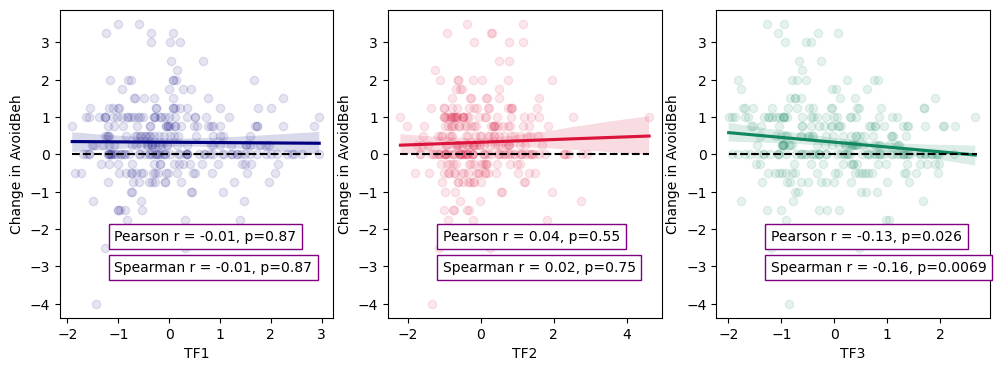

In [145]:
## variable used for aligning
var2use = "cases14_norm_unsmooth"


#for v in vars:
sumdf = pd.DataFrame()
for vidx, v in enumerate(vars):

    # Extract trait values for each 
    tdf = df.groupby(by=["PROLIFICID"]).mean()[trait_factor_names_short].reset_index()
    tdf=tdf.set_index("PROLIFICID")

    # get the realigned data for a variable of interest (F1 in this case)
    maxs=df.groupby(by=["PROLIFICID"])["session", v, var2use].apply(realign_time_series, 
                                                                                        var_to_align=v, 
                                                                                        var_align_by=var2use, 
                                                                                        baseline='none', 
                                                                                        applyfunc='none', 
                                                                                        #method='cumsum-min',
                                                                                        method='fixed',
                                                                                        sessionfix =13,
                                                                                        ).reset_index()
    #maxs=maxs.set_index("PROLIFICID")
    #
    #maxs['newsess'].replace({0: 'pre',  1: 'post'}, inplace=True)
    #maxs['newsess'].replace({1: 'pre', 2: 'pre', 3: 'pre',  8: 'post', 9: 'post', 10: 'post'}, inplace=True)
    maxs['newsess'].replace({2: 'pre', 3:'pre',  8: 'post', 9: 'post'}, inplace=True)
    
    maxs = maxs.loc[maxs["newsess"].isin(['pre', 'post']),:]

    # join data sets 
    
    maxs = maxs.loc[:,["newsess", "PROLIFICID", v+"_realigned"]].groupby(by=["newsess", "PROLIFICID"]).mean().reset_index()
    maxs = maxs.pivot(columns="newsess", index="PROLIFICID", values=v+"_realigned")

    maxs["prepost"] = maxs["post"] - maxs["pre"]

    maxs = maxs.join(tdf, how="left")

    ### for export 
    ccf = maxs.copy()
    ccf = ccf.rename(columns={"pre": "pre_"+v, "post": "post_"+v, "prepost": "prepost_"+v})
    if vidx == 0:
        ppdata2 = ccf
        ppdata2["wave"] = "first_wave"
    else:
        ppdata2 = ppdata2.join(ccf.loc[:,["pre_"+v, "post_"+v,  "prepost_"+v]])


    # Gather summary data
    stats = maxs[['pre', 'post', 'prepost']].agg(['mean', 'std'])
    stats.loc['se'] = stats.loc['std'] / np.sqrt(len(maxs))
    summary_data = {}

    for stat in stats.index:  # Iterate over 'mean', 'std', 'se'
        for col in stats.columns:  # Iterate over 'pre', 'post', 'prepost'
            summary_data[f'{col}_{stat}'] = stats.loc[stat, col]

    # Step 2: Calculate Spearman correlations for pre, post, and prepost with TF1, TF2, and TF3
    for variable in ['pre', 'post', 'prepost']:
        for tf in ['TF1', 'TF2', 'TF3']:
            corr = pg.corr(maxs[variable], maxs[tf], method='spearman')
            ci_lower, ci_upper = corr['CI95%'].values[0]  # Split the CI95% into lower and upper bounds
            summary_data.update({
                f'{variable}_{tf}_rho': corr['r'].values[0],
                f'{variable}_{tf}_pval': corr['p-val'].values[0],
                f'{variable}_{tf}_CI_lower': ci_lower,
                f'{variable}_{tf}_CI_upper': ci_upper
            })

    ttf = pd.DataFrame([summary_data])
    ttf["var"] = v
    sumdf = pd.concat([sumdf, ttf])

    # plot
    f, ax = plt.subplots(1,3,figsize=(12,4))


    for ttidx, tt in enumerate(trait_factor_names_short):
        ax[ttidx] = sns.regplot(data=maxs, x=tt, y="prepost", ax=ax[ttidx], line_kws={'color': colist[ttidx][0]}, scatter_kws={'color':colist[ttidx][0]  ,'alpha':0.1})
        corrfunc(maxs[tt], maxs["prepost"], drop_missing=True, tests=["pearson","spearman"], ax=ax[ttidx], xanchor=0.2)
        ax[ttidx].set_ylabel("Change in "+v)
        ax[ttidx].plot([min(maxs[tt]), max(maxs[tt])], [0,0], 'k--')
    plt.savefig(os.path.join(root_dir, 'covid-fear', 'scripts', 'submissions_and_outputs',  'PUG_2024', 'raw_plots', 'ER_'+v+'.pdf'), dpi=300, quality=80, optimize=True, progressive=True)  


ppdata2.to_csv(os.path.join(root_dir, "output", "prepost", "second_wave_full_prepost_data.csv"))

In [146]:
for w in ["pre", "post", "prepost"]:
    pvs = sumdf.loc[:,["var"]+[w+"_"+x+"_pval" for x in ["TF1", "TF2", "TF3"]]].melt(value_name="pval", id_vars="var")
    pvs.loc[:,"pval_corr"] = pg.multicomp(pvs["pval"], alpha=0.05, method="holm")[1]
    app = pvs.pivot(columns="variable", index="var", values=["pval_corr"])
    app.columns = app.columns.get_level_values(1)
    app = app.rename(columns={w+"_TF1_pval": w+"_TF1_pval_corr", 
                        w+"_TF2_pval": w+"_TF2_pval_corr",
                        w+"_TF3_pval": w+"_TF3_pval_corr"})

    sumdf = sumdf.set_index("var").join(app).reset_index()


In [147]:
# Assuming you have your data in 'sumdf' DataFrame and 'vars' list
summary_df = sumdf.copy()
summary_df.index = vars  # Setting the index to vars (your variable names)
summary_df = summary_df.T  # Transposing the DataFrame for easier access
summary_df

Deaths     Cases  ThreatPerc     Worry   RiskEsts  \
var                      Deaths     Cases  ThreatPerc     Worry   RiskEsts   
pre_mean              -0.772796 -0.577792    4.388333  3.250417  30.352778   
post_mean                0.3934  1.483073    5.531359  3.508711    33.5482   
prepost_mean            1.18103  2.091274    1.172474  0.261106   3.350755   
pre_std                0.191358  0.242121    1.530088  1.405773  19.177099   
post_std               0.650831  0.586868    1.295794  1.371212    18.5344   
prepost_std            0.703213  0.633636    1.249073  0.632947   8.217416   
pre_se                 0.011048  0.013979     0.08834  0.081162    1.10719   
post_se                0.037576  0.033883    0.074813  0.079167   1.070084   
prepost_se               0.0406  0.036583    0.072115  0.036543   0.474433   
pre_TF1_rho           -0.152591 -0.138154     0.19639  0.398813   0.197885   
pre_TF1_pval           0.009012  0.016647    0.000624       0.0   0.000566   
pre_TF1_CI_lower          -0.26     -0.25        0.09       0.3       0.09   
pre_TF1_CI_upper          -0.04     -0.03         0.3      0.49        0.3   
pre_TF2_rho            0.019406 -0.017054    0.188946  0.277216   0.197564   
pre_TF2_pval           0.741241   0.76862    0.001007  0.000001   0.000578   
pre_TF2_CI_lower           -0.1     -0.13        0.08      0.17       0.09   
pre_TF2_CI_upper           0.13       0.1         0.3      0.38        0.3   
pre_TF3_rho            -0.29498  -0.25235    0.100903  0.357553   0.139009   
pre_TF3_pval                0.0   0.00001     0.08101       0.0    0.01598   
pre_TF3_CI_lower           -0.4     -0.36       -0.01      0.25       0.03   
pre_TF3_CI_upper          -0.19     -0.14        0.21      0.45       0.25   
post_TF1_rho           0.030442 -0.085134    0.140857  0.384694    0.22828   
post_TF1_pval          0.614573  0.150268    0.016951       0.0   0.000095   
post_TF1_CI_lower         -0.09      -0.2        0.03      0.28       0.12   
post_TF1_CI_upper          0.15      0.03        0.25      0.48       0.34   
post_TF2_rho          -0.016114 -0.047437    0.210419  0.287746   0.236746   
post_TF2_pval          0.789845  0.423378    0.000331  0.000001   0.000051   
post_TF2_CI_lower         -0.13     -0.16         0.1      0.18       0.12   
post_TF2_CI_upper           0.1      0.07        0.32      0.39       0.34   
post_TF3_rho           0.045075  0.000004    0.015117  0.314219   0.130537   
post_TF3_pval          0.455778  0.999945    0.798727       0.0   0.027018   
post_TF3_CI_lower         -0.07     -0.12        -0.1      0.21       0.01   
post_TF3_CI_upper          0.16      0.12        0.13      0.41       0.24   
prepost_TF1_rho        0.043649 -0.048352   -0.052414 -0.008659   0.029791   
prepost_TF1_pval       0.470171  0.414477    0.376325  0.883871    0.61525   
prepost_TF1_CI_lower      -0.07     -0.16       -0.17     -0.12      -0.09   
prepost_TF1_CI_upper       0.16      0.07        0.06      0.11       0.15   
prepost_TF2_rho       -0.026707 -0.044202   -0.011482  0.071233   0.080688   
prepost_TF2_pval        0.65867  0.455707    0.846436  0.228969   0.172817   
prepost_TF2_CI_lower      -0.14     -0.16       -0.13     -0.04      -0.04   
prepost_TF2_CI_upper       0.09      0.07         0.1      0.19       0.19   
prepost_TF3_rho        0.082887  0.057156   -0.077998 -0.121203  -0.063615   
prepost_TF3_pval        0.16971  0.334618    0.187635  0.040177    0.28278   
prepost_TF3_CI_lower      -0.04     -0.06       -0.19     -0.23      -0.18   
prepost_TF3_CI_upper        0.2      0.17        0.04     -0.01       0.05   
pre_TF1_pval_corr      0.090118  0.143823    0.008493       0.0   0.008493   
pre_TF2_pval_corr           1.0       1.0     0.01208  0.000019   0.008493   
pre_TF3_pval_corr      0.000005  0.000155    0.567073       0.0   0.143823   
post_TF1_pval_corr          1.0       1.0    0.220361       0.0   0.001621   
post_TF2_pval_corr          1.0       1.0    0.

In [148]:
from docx import Document
from docx.shared import Inches, Pt
from docx.enum.table import WD_ALIGN_VERTICAL, WD_TABLE_ALIGNMENT
from docx.enum.text import WD_ALIGN_PARAGRAPH
import os

# Create a new Document
doc = Document()

# Set the document to landscape orientation
section = doc.sections[-1]
section.orientation = 1  # Set orientation to landscape
new_width, new_height = section.page_height, section.page_width
section.page_width = new_width
section.page_height = new_height

# Set margins (optional)
section.top_margin = Inches(1)
section.bottom_margin = Inches(1)
section.left_margin = Inches(1)
section.right_margin = Inches(1)

# Create the table with the appropriate number of rows and columns
rows = len(vars) + 2  # +2 for the header rows
cols = 13  # Variable column + 3 (pre, post, prepost) for Summary + 9 for TF1, TF2, TF3

table = doc.add_table(rows=rows, cols=cols)

# Set table alignment to center
table.alignment = WD_TABLE_ALIGNMENT.CENTER

# Add header rows
header_cells = table.rows[0].cells
header_cells[0].text = "Variable"
header_cells[1].text = "Summary"
header_cells[4].text = "TF1"
header_cells[7].text = "TF2"
header_cells[10].text = "TF3"

# Merge header cells for subcolumns
header_cells[1].merge(header_cells[2]).merge(header_cells[3])
header_cells[4].merge(header_cells[5]).merge(header_cells[6])
header_cells[7].merge(header_cells[8]).merge(header_cells[9])
header_cells[10].merge(header_cells[11]).merge(header_cells[12])

# Add subheader row
subheader_cells = table.rows[1].cells
subheader_cells[1].text = "Pre"
subheader_cells[2].text = "Post"
subheader_cells[3].text = "Prepost"
subheader_cells[4].text = "Pre"
subheader_cells[5].text = "Post"
subheader_cells[6].text = "Prepost"
subheader_cells[7].text = "Pre"
subheader_cells[8].text = "Post"
subheader_cells[9].text = "Prepost"
subheader_cells[10].text = "Pre"
subheader_cells[11].text = "Post"
subheader_cells[12].text = "Prepost"

# Define column widths
for cell in table.columns[1].cells:
    cell.width = Inches(0.8)  # Narrower summary columns
for i in range(4, 13):
    for cell in table.columns[i].cells:
        cell.width = Inches(0.7)  # 20% narrower for TF1-TF3 subcolumns

# Add the table data
for i, var in enumerate(vars):
    row_cells = table.rows[i + 2].cells
    row_cells[0].text = var  # Variable name
    row_cells[1].text = f"{summary_df[var]['pre_mean']:.2f} ± {summary_df[var]['pre_std']:.2f}"
    row_cells[2].text = f"{summary_df[var]['post_mean']:.2f} ± {summary_df[var]['post_std']:.2f}"
    row_cells[3].text = f"{summary_df[var]['prepost_mean']:.2f} ± {summary_df[var]['prepost_std']:.2f}"

    def format_docx_correlation(cell, rho, pval_uncorr, pval_corr, ci_lower, ci_upper):
        p = cell.paragraphs[0]
        run = p.add_run(f"ρ={rho:.2f}\n")
        run.italic = True
        run = p.add_run(f"CI95=[{ci_lower:.2f}, {ci_upper:.2f}]\n")
        run = p.add_run("p<0.001" if pval_uncorr < 0.001 else f"p={pval_uncorr:.3f}")
        run = p.add_run("\n")
        run = p.add_run("pcorr<0.001" if pval_corr < 0.001 else f"pcorr={pval_corr:.3f}")
        if pval_corr < 0.05:
            for run in p.runs:  # Apply bold to the entire cell content
                run.bold = True
        p.alignment = WD_ALIGN_PARAGRAPH.CENTER

    format_docx_correlation(row_cells[4], summary_df[var]['pre_TF1_rho'], summary_df[var]['pre_TF1_pval'], summary_df[var]['pre_TF1_pval_corr'], summary_df[var]['pre_TF1_CI_lower'], summary_df[var]['pre_TF1_CI_upper'])
    format_docx_correlation(row_cells[5], summary_df[var]['post_TF1_rho'], summary_df[var]['post_TF1_pval'], summary_df[var]['post_TF1_pval_corr'], summary_df[var]['post_TF1_CI_lower'], summary_df[var]['post_TF1_CI_upper'])
    format_docx_correlation(row_cells[6], summary_df[var]['prepost_TF1_rho'], summary_df[var]['prepost_TF1_pval'], summary_df[var]['prepost_TF1_pval_corr'], summary_df[var]['prepost_TF1_CI_lower'], summary_df[var]['prepost_TF1_CI_upper'])

    format_docx_correlation(row_cells[7], summary_df[var]['pre_TF2_rho'], summary_df[var]['pre_TF2_pval'], summary_df[var]['pre_TF2_pval_corr'], summary_df[var]['pre_TF2_CI_lower'], summary_df[var]['pre_TF2_CI_upper'])
    format_docx_correlation(row_cells[8], summary_df[var]['post_TF2_rho'], summary_df[var]['post_TF2_pval'], summary_df[var]['post_TF2_pval_corr'], summary_df[var]['post_TF2_CI_lower'], summary_df[var]['post_TF2_CI_upper'])
    format_docx_correlation(row_cells[9], summary_df[var]['prepost_TF2_rho'], summary_df[var]['prepost_TF2_pval'], summary_df[var]['prepost_TF2_pval_corr'], summary_df[var]['prepost_TF2_CI_lower'], summary_df[var]['prepost_TF2_CI_upper'])

    format_docx_correlation(row_cells[10], summary_df[var]['pre_TF3_rho'], summary_df[var]['pre_TF3_pval'], summary_df[var]['pre_TF3_pval_corr'], summary_df[var]['pre_TF3_CI_lower'], summary_df[var]['pre_TF3_CI_upper'])
    format_docx_correlation(row_cells[11], summary_df[var]['post_TF3_rho'], summary_df[var]['post_TF3_pval'], summary_df[var]['post_TF3_pval_corr'], summary_df[var]['post_TF3_CI_lower'], summary_df[var]['post_TF3_CI_upper'])
    format_docx_correlation(row_cells[12], summary_df[var]['prepost_TF3_rho'], summary_df[var]['prepost_TF3_pval'], summary_df[var]['prepost_TF3_pval_corr'], summary_df[var]['prepost_TF3_CI_lower'], summary_df[var]['prepost_TF3_CI_upper'])

# Adjust font size and style for the entire table
for row in table.rows:
    for cell in row.cells:
        for paragraph in cell.paragraphs:
            for run in paragraph.runs:
                run.font.size = Pt(6)  # Reduce the font size by 40%
                run.font.name = 'Calibri'

# Save the document
doc_output_path = os.path.join(root_dir, "output", "prepost", "wave2_table.docx")
doc.save(doc_output_path)

print(f"Word document has been created and saved to {doc_output_path}")


Word document has been created and saved to /data/drive/postdoc/Project4_covid/output/prepost/wave2_table.docx
